In [1]:
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.feature_extraction import DictVectorizer
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
import pickle
import mlflow

In [2]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1722989988527, experiment_id='1', last_update_time=1722989988527, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [ ]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']

df[categorical] = df[categorical].astype(str)

In [18]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
x_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

reg = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.8, n_estimators=500, verbosity=2)
reg.fit(x_train, y_train)

y_pred = reg.predict(x_train)

root_mean_squared_error(y_train, y_pred)

np.float64(3.4804001897516237)

/tmp/ipykernel_3913/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_3913/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


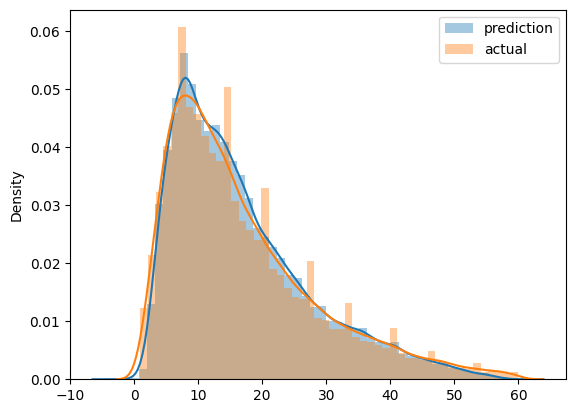

In [19]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [3]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [4]:
df_train = read_dataframe('./data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('./data/green_tripdata_2021-02.parquet')

In [5]:
len(df_train), len(df_val)

(73908, 61921)

In [6]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [7]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [8]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [14]:
reg = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.8, n_estimators=500, verbosity=2)
reg.fit(X_train, y_train)

y_pred = reg.predict(X_val)

root_mean_squared_error(y_val, y_pred)

6.429234961685116

In [15]:
with open('models/xgb_reg.bin', 'wb') as f_out:
    pickle.dump((dv, reg), f_out)

In [16]:
with mlflow.start_run():

    mlflow.set_tag("developer", "ivan")

    mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.parquet")
    mlflow.log_param("validation-data-path", "./data/green_tripdata_2021-02.parquet")

    lr = 0.07
    mlflow.log_param("learning rate", lr)
    reg = xgb.XGBRegressor(learning_rate=lr)
    reg.fit(X_train, y_train)

    y_pred = reg.predict(X_val)

    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

In [17]:
from hyperopt import fmin,tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [9]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [20]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [21]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:24:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.63670                           
[1]	validation-rmse:8.17720                           
[2]	validation-rmse:7.38684                           
[3]	validation-rmse:6.97346                           
[4]	validation-rmse:6.75227                           
[5]	validation-rmse:6.63131                           
[6]	validation-rmse:6.56173                           
[7]	validation-rmse:6.52105                           
[8]	validation-rmse:6.49654                           
[9]	validation-rmse:6.47918                           
[10]	validation-rmse:6.46419                          
[11]	validation-rmse:6.45483                          
[12]	validation-rmse:6.44587                          
[13]	validation-rmse:6.43945                          
[14]	validation-rmse:6.43603                          
[15]	validation-rmse:6.43315                          
[16]	validation-rmse:6.43009                          
[17]	validation-rmse:6.42207                          
[18]	valid

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:26:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.45282                                                     
[1]	validation-rmse:10.78790                                                     
[2]	validation-rmse:10.20837                                                     
[3]	validation-rmse:9.69845                                                      
[4]	validation-rmse:9.26145                                                      
[5]	validation-rmse:8.87755                                                      
[6]	validation-rmse:8.55076                                                      
[7]	validation-rmse:8.26348                                                      
[8]	validation-rmse:8.02298                                                      
[9]	validation-rmse:7.81121                                                      
[10]	validation-rmse:7.63267                                                     
[11]	validation-rmse:7.48315                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:30:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.46873                                                      
[1]	validation-rmse:10.81563                                                      
[2]	validation-rmse:10.24507                                                      
[3]	validation-rmse:9.74791                                                       
[4]	validation-rmse:9.31663                                                       
[5]	validation-rmse:8.94348                                                       
[6]	validation-rmse:8.62185                                                       
[7]	validation-rmse:8.34550                                                       
[8]	validation-rmse:8.10858                                                       
[9]	validation-rmse:7.90615                                                       
[10]	validation-rmse:7.73267                                                      
[11]	validation-rmse:7.58517                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [03:34:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.50443                                                      
[1]	validation-rmse:10.87970                                                      
[2]	validation-rmse:10.32516                                                      
[3]	validation-rmse:9.83810                                                       
[4]	validation-rmse:9.41155                                                       
[5]	validation-rmse:9.03438                                                       
[6]	validation-rmse:8.70843                                                       
[7]	validation-rmse:8.42021                                                       
[8]	validation-rmse:8.17375                                                       
[9]	validation-rmse:7.95339                                                       
[10]	validation-rmse:7.77092                                                      
[11]	validation-rmse:7.60908                                                      
[12]

KeyboardInterrupt: 

In [19]:
params= {
    'learning_rate': 0.33166586938408643,
    'max_depth':72,
    'min_child_weight': 2.968412805214042,
    'objective': 'reg:linear',
    'reg_alpha': 0.037155048659385764,
    'reg_lambda': 0.2141194706610498,
    'seed':42
}

with mlflow.start_run():
    mlflow.log_params(params)
    evals_result = {}
    booster = xgb.train(
                params=params,
                dtrain=train,
                num_boost_round=1000,
                evals=[(valid, 'validation')],
                early_stopping_rounds=50,
                evals_result=evals_result
            )
    
best_iteration = booster.best_iteration
best_rmse = evals_result['validation']['rmse'][best_iteration]
best_learning_rate = params['learning_rate']
mlflow.log_params('learning_rate', best_learning_rate)
mlflow.log_metric('rmse', best_rmse)
mlflow.end_run()
   

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [04:03:48] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.63670
[1]	validation-rmse:8.17720
[2]	validation-rmse:7.38684
[3]	validation-rmse:6.97346
[4]	validation-rmse:6.75227
[5]	validation-rmse:6.63131
[6]	validation-rmse:6.56173
[7]	validation-rmse:6.52105
[8]	validation-rmse:6.49654
[9]	validation-rmse:6.47918
[10]	validation-rmse:6.46419
[11]	validation-rmse:6.45483
[12]	validation-rmse:6.44587
[13]	validation-rmse:6.43945
[14]	validation-rmse:6.43603
[15]	validation-rmse:6.43315
[16]	validation-rmse:6.43009
[17]	validation-rmse:6.42207
[18]	validation-rmse:6.41751
[19]	validation-rmse:6.41421
[20]	validation-rmse:6.41078
[21]	validation-rmse:6.40910
[22]	validation-rmse:6.40674
[23]	validation-rmse:6.40449
[24]	validation-rmse:6.40189
[25]	validation-rmse:6.39989
[26]	validation-rmse:6.39729
[27]	validation-rmse:6.39691
[28]	validation-rmse:6.39539
[29]	validation-rmse:6.39376
[30]	validation-rmse:6.39271
[31]	validation-rmse:6.39121
[32]	validation-rmse:6.38964
[33]	validation-rmse:6.38844
[34]	validation-rmse:6.3

AttributeError: 'str' object has no attribute 'items'

In [18]:
mlflow.end_run()

MlflowException: The run ca1bcb8aa08e456f9e4244d7a54f7ef8 must be in the 'active' state. Current state is deleted.